# Global preparations

In [79]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.transforms.functional import to_pil_image
from PIL import Image
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:3'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
logger = logging.getLogger('stdout_logger')
logger.setLevel(logging.INFO)
if not logger.hasHandlers():
    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setFormatter(logging.Formatter(fmt='%(asctime)s|%(levelname)s|%(message)s'))
    logger.addHandler(stdout_handler)
print(torch.__version__)

2.1.2+cu121


# Text data preparation

Let's read tinyshakespeare.txt

In [3]:
CONTEXT_SIZE = 32

In [4]:
from spiky.util.text_snippet_sampler import TextSnippetSampler

#snippet_sampler = TextSnippetSampler('tinyshakespeare.txt', CONTEXT_SIZE + 1, 1000, device)
snippet_sampler = TextSnippetSampler('fineweb_texts.txt', CONTEXT_SIZE + 1, 1000, device)

In [5]:
snippet_sampler.sample_training_batch(2)

tensor([[111, 117, 114,  32, 116, 101,  97,  99, 104, 101, 114,  32, 102, 111,
         114,  32,  97,  32, 115, 116, 117, 100, 121,  32, 103, 117, 105, 100,
         101,  46,  32,  73, 102],
        [115, 104, 105, 111, 110,  32,  97, 110, 100,  32,  99, 108, 111, 116,
         104, 105, 110, 103,  32,  97, 114, 101,  97, 115,  44,  32,  97,  32,
         118, 101, 114, 121,  32]], device='cuda:3', dtype=torch.int32)

In [6]:
snippet_sampler.batch_to_text(snippet_sampler.sample_training_batch(4))

['d is fallen from heaven, and hath',
 'ts in solitary confinement. Adult',
 'ECG Technology in the Medical Wor',
 're easily.\n"Similar projects over']

In [7]:
for test_batch in snippet_sampler.testing_batches_iterator(4):
    print(snippet_sampler.batch_to_text(test_batch))
    break

[' in any other higher education se', 'n Vidal discovers, other causes a', 'ers, gorillas, and other celebrit', 'ination of their representatives,']


# Simple LUT transformer

In [60]:
from spiky.lut.LUTLayer import GradientPolicy, GradientType, SynapseMeta
from spiky.lut.LUTTransformer import LUTTransformer
from spiky.lut.tests.gt_lut_product import GTLUTProductTransformer
lut_transformer = None
optimizer = None
sched = None
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
lut_transformer = LUTTransformer(
    vocab_size=256,
    embedding_dim=32,
    context_size=CONTEXT_SIZE,
    positional_dim=4,
    # no_ffn=True,
    # use_sinusoidal_pe=True,
    # inject_pe_once=True,
    num_layers=6,
    num_heads=4,
    n_detectors=16,
    n_anchors_per_detector_attention=6,
    n_anchors_per_detector=10,
    concatenation_product=True,
    dropout=0.0,
    use_batch_norm=True,
    use_biases=True,
    layer_norm_d=None,
    #_synapse_meta=SynapseMeta(min_weight=0.0, max_weight=5.0, initial_weight=5.0, initial_noise_level=-5.0),
    #do_normalise_weights=True,
    weights_gradient_policy=GradientPolicy(GradientType.Dense),
    relu_before_luts=False,
    device=device,
    seed=random_seed,
    _forward_group_size=32,
    _backward_group_size=32
)
# lut_transformer = GTLUTProductTransformer(
#     vocab_size=256,
#     embedding_dim=32,
#     context_size=CONTEXT_SIZE,
#     positional_dim=8,
#     num_layers=6,
#     num_heads=4,
#     n_detectors=32,
#     n_anchors_per_detector_attention=8,
#     n_anchors_per_detector=10,
#     device=device,
#     seed=None,
#     _forward_group_size=64,
#     _backward_group_size=64
# )
print(lut_transformer)

LUTTransformer(
  (token_embedder): Embedding(256, 32)
  (layers): ModuleList(
    (0-5): 6 x ModuleDict(
      (attention_lut): LUTLayer(32 inputs, 64 detectors, 32 outputs, 6 anchors per detector)
      (attention_dropout): Dropout(p=0.0, inplace=False)
      (attention_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (attention_ln): None
      (ffn): LUTLayer(32 inputs, 16 detectors, 32 outputs, 10 anchors per detector)
      (ffn_dropout): Dropout(p=0.0, inplace=False)
      (ffn_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ffn_ln): None
    )
  )
  (unembedder): LUTLayer(32 inputs, 16 detectors, 256 outputs, 10 anchors per detector)
)


In [61]:
total = sum(p.numel() for p in lut_transformer.parameters())
trainable = sum(p.numel() for p in lut_transformer.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 812703616
trainable: 812695424
frozen: 8192


In [62]:
import math
from typing import Iterable, Optional, Tuple, Dict

import torch


class CustomAdam(torch.optim.Optimizer):
    def __init__(
        self,
        params: Iterable[torch.nn.Parameter],
        lr: float = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.999),
        eps: float = 1e-8,
        weight_decay: float = 0.0,  # L2-style (coupled) like torch.optim.Adam
    ):
        if lr < 0:
            raise ValueError("lr must be >= 0")
        b1, b2 = betas
        if not (0 <= b1 < 1 and 0 <= b2 < 1):
            raise ValueError("betas must be in [0,1)")
        if eps <= 0:
            raise ValueError("eps must be > 0")
        if weight_decay < 0:
            raise ValueError("weight_decay must be >= 0")

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure: Optional[callable] = None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr: float = group["lr"]
            b1, b2 = group["betas"]
            eps: float = group["eps"]
            wd: float = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                if p.grad.is_sparse:
                    raise RuntimeError("SimpleAdam does not support sparse gradients")

                g = p.grad

                # "Coupled" weight decay (L2 penalty) like torch.optim.Adam
                if wd != 0.0:
                    g = g.add(p, alpha=wd)

                state: Dict = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["m"] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state["v"] = torch.zeros_like(p, memory_format=torch.preserve_format)

                m = state["m"]
                v = state["v"]
                state["step"] += 1
                t = state["step"]

                # Update biased first/second moments
                m.mul_(b1).add_(g, alpha=1.0 - b1)
                v.mul_(b2).addcmul_(g, g, value=1.0 - b2)

                # Bias correction
                m_hat = m / (1.0 - b1 ** t)
                v_hat = v / (1.0 - b2 ** t)

                # Parameter update
                p.addcdiv_(m_hat, v_hat.sqrt().add_(eps), value=-lr)

        return loss


In [63]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from spiky.util.torch_utils import make_lr_getter

def lr_func(t):
    return min(
        0.001 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

lr = 0.001
#optimizer = optim.SGD(lut_transformer.parameters(), lr=lr)
#optimizer = optim.Adam(lut_transformer.parameters(), lr=lr)
optimizer = CustomAdam(lut_transformer.parameters(), lr=lr)

steps=150000
batch_size = 64
sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=steps
)
#sched = LambdaLR(optimizer, lr_lambda=lr_func)
#sched = None
#lut_transformer.set_external_learning_rate_hook(make_lr_getter(optimizer))

In [64]:
lut_train_losses = []
lut_test_losses = []

In [65]:
import torch
import torch.nn.functional as F
from torch.optim import Adam, SGD

test_batch_size = 128

def generate_text_lut(lut_model, prefix, length, device):
    ctx = list(prefix.encode("utf-8"))
    ctx = ctx[-CONTEXT_SIZE:]

    for _ in range(length):
        x = torch.zeros([CONTEXT_SIZE], dtype=torch.long, device=device).unsqueeze(0)
        trunc_ctx = ctx[-CONTEXT_SIZE:]
        x[0, -len(trunc_ctx):] = torch.tensor(trunc_ctx, dtype=torch.long, device=device) 
        logits = lut_model(x)
        probs = torch.softmax(logits[:,-1,:], dim=-1)[0]
        next_id = torch.multinomial(probs, 1).item()
        ctx.append(next_id)

    ctx_safe = [c if c != 0 else 32 for c in ctx]
        
    return bytes(ctx_safe).decode("latin1", errors="ignore")

def evaluate_model(model, sampler, B):
    model.eval()
    losses = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in sampler.testing_batches_iterator(B):   # [B, C]
            inp = batch[:, :-1]          # [B, C-1]
            tgt = batch[:, 1:].long()    # [B, C-1]

            logits = model(inp)   # [B, C-1, 256]

            B_, T, V = logits.shape
            loss = F.cross_entropy(
                logits.reshape(B_ * T, V),
                tgt.reshape(B_ * T)
            )
            losses.append(loss.item())

    # ---- small generation demo ----
    prefix = "Once upon a time "
    gen = generate_text_lut(model, prefix, length=80, device=device)
    print("\n[GEN]:", gen, "\n")

    model.train()
    return sum(losses) / len(losses) #  / (CONTEXT_SIZE * B)

In [66]:
test_every=1000
train_loss = None
alpha = 0.01

pbar = tqdm(total=steps)
lut_transformer.train()

for step in range(0, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size)   # [B, C]
    inp = x[:, :-1]                                         # [B, C-1]
    tgt = x[:, 1:].long()                                   # [B, C-1]

    logits = lut_transformer(inp)      # [B, C-1, 256]

    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.reshape(B * T, V),
        tgt.reshape(B * T),
        reduction='none'
    ).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if sched is not None:
        # for _ in range(x.shape[0]):
        sched.step()

    loss_value = loss.item() / (CONTEXT_SIZE * batch_size)
    train_loss = loss_value if train_loss is None else (1 - alpha) * train_loss + alpha * loss_value
    pbar.update(1)
    if step % 10 == 0:
        pbar.set_description(f"loss={train_loss:.4f}, lr {lr if sched is None else sched.get_last_lr()[0]:.8f}")

    if step % test_every == 0:
        test_loss = evaluate_model(lut_transformer, snippet_sampler, test_batch_size)
        if len(lut_train_losses) == 0 or step > 0:
            lut_train_losses.append(train_loss)
            lut_test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")

  0%|          | 0/150000 [00:00<?, ?it/s]


[GEN]: Once upon a time ínZ»zÆ®7ð#Yz/µIì¶x6v*[Xð´ë3;ÛÑU¿SÝµ¹½ñ^ñ}g#ÿóëmôUÑn$Su"`äÈ5MU 

[TEST] step 0: loss=5.5171

[GEN]: Once upon a time un she all is hapand skestlan thWigh, Neleas forage hasts an21199
E/_ r as  who 

[TEST] step 1000: loss=2.1456

[GEN]: Once upon a time nee this action. (1348%.
CMVU propesshouban Surcorabing Kiftwhilosing and seshou 

[TEST] step 2000: loss=1.9037

[GEN]: Once upon a time nativodomeans invour ordinates sivilizate loop to no/gensnens her rieted are is  

[TEST] step 3000: loss=1.7954

[GEN]: Once upon a time stemge
Amer more than 180 and state lift is pice, sip goe, and descresswho myvic 

[TEST] step 4000: loss=1.7399

[GEN]: Once upon a time deformine, or under (hride participation and who work the restevet to the sensis 

[TEST] step 5000: loss=1.6955

[GEN]: Once upon a time meditable presentence a referetage of an itrony nerative its, jained for his a t 

[TEST] step 6000: loss=1.6760

[GEN]: Once upon a time for whibe n

KeyboardInterrupt: 

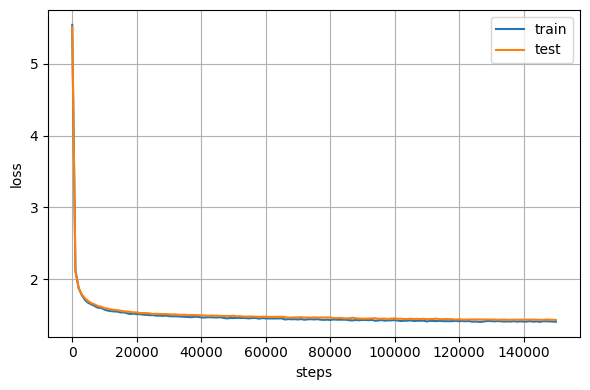

In [55]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
lut_test_losses[-1]

1.4303922802209854

In [ ]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

steps = [i * 1000 for i in range(len(lut_train_losses))]

plt.figure(figsize=(6,4))
plt.plot(steps, lut_train_losses, label="train")
plt.plot(steps, lut_test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
generate_text_lut(lut_transformer, 'Once upon a time: ', length=80, device=device)

In [ ]:
print(lut_transformer.get_profile_statistics())

In [ ]:
evaluate_model(lut_transformer, snippet_sampler, 4)

In [ ]:
import torch
import torch.nn as nn

from spiky.lut.LUTLayer import (
    LUTLayer,
    Conv2DLUTLayer,
    LUTSharedContext,
    GradientPolicy,
    GradientType,
    MultiLUT,
    SynapseMeta
)

from spiky.lut.tests.gt_lut_product import GTLUTProduct

class LUTTransformerExp(nn.Module):
    def _create_single_attention(
        self, _synapse_meta, summation_dtype, _int_rescaler, seed,
        _forward_group_size, _backward_group_size, num_heads
    ):
#         return LUTLayer(
#             n_inputs=self.embedding_dim,
#             n_outputs=self.embedding_dim,
#             n_detectors=self.n_detectors * num_heads,
#             n_anchors_per_detector=self.n_anchors_per_detector_attention,
#             sequence_length=self.context_size,
#             synapse_meta=_synapse_meta,
#             positional_dim=self.positional_dim,
#             weights_gradient_policy=self.weights_gradient_policy,
#             shared_context=self.lut_shared_context,
#             summation_dtype=summation_dtype,
#             _int_rescaler=_int_rescaler,
#             device=self.device,
#             random_seed=seed,
#             _forward_group_size=_forward_group_size,
#             _backward_group_size=_backward_group_size
#         )
        return GTLUTProduct(
            n_inputs_1=self.embedding_dim,
            n_inputs_2=self.embedding_dim,
            positional_dim=self.positional_dim,
            n_outputs=self.embedding_dim,
            sequence_length=self.context_size,
            sliced_mode=False,
            n_detectors=self.n_detectors * num_heads,
            n_anchors_per_detector=self.n_anchors_per_detector_attention,
            synapse_meta=_synapse_meta,
            weights_gradient_policy=self.weights_gradient_policy,
            shared_context=self.lut_shared_context,
            summation_dtype=summation_dtype,
            random_seed=seed,
            device=self.device
        )


    def __init__(
        self, vocab_size, embedding_dim, context_size,
        positional_dim, num_layers, num_heads,
        n_detectors, n_anchors_per_detector, weights_gradient_policy=None,
        device=None, _synapse_meta=SynapseMeta(), _use_multi_lut=False,
        lut_shared_context=None, seed=None, summation_dtype=torch.float32, _int_rescaler=0.001,
        _forward_group_size=32, _backward_group_size=32, dropout=0.1,
        n_anchors_per_detector_attention=None
    ):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.context_size = context_size
        self.positional_dim = positional_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.n_detectors = n_detectors
        self.n_anchors_per_detector = n_anchors_per_detector
        # If not specified, use the same value as n_anchors_per_detector for backward compatibility
        self.n_anchors_per_detector_attention = n_anchors_per_detector_attention if n_anchors_per_detector_attention is not None else n_anchors_per_detector
        self.weights_gradient_policy = weights_gradient_policy
        self.dropout = dropout
        if device is None:
            device = torch.device('cpu')

        self.device = device

        if lut_shared_context is None:
            self.lut_shared_context = LUTSharedContext()
            self.lut_shared_context.to_device(device)
        else:
            self.lut_shared_context = lut_shared_context

        n_embeddings = embedding_dim

        self.token_embedder = nn.Embedding(vocab_size, n_embeddings, device=device)
        self.token_embedder.weight.requires_grad_(False)
        if seed is not None:
            gen = torch.Generator(device=device)
            gen.manual_seed(seed)
            w = 2 * torch.rand(self.token_embedder.weight.shape, generator=gen, device=device) - 1.0
            self.token_embedder.weight.copy_(w)
        else:
            nn.init.uniform_(self.token_embedder.weight, -1.0, 1.0)

        # Dropout after embeddings
        self.embedding_dropout = nn.Dropout(dropout)
        
#         pe = build_sinusoidal_pe(context_size, positional_dim, device)
#         self.register_buffer("pos_emb", pe.unsqueeze(0))

        # Transformer layers
        self.layers = nn.ModuleList()
        for layer_idx in range(num_layers):
            layer = nn.ModuleDict()

            # Attention heads
            if _use_multi_lut:
                heads = []
                for head_idx in range(num_heads):
                    attention_lut = self._create_single_attention(
                        _synapse_meta=_synapse_meta, summation_dtype=summation_dtype,
                        _int_rescaler=_int_rescaler,
                        seed=None if seed is None else seed + layer_idx * num_heads + head_idx,
                        _forward_group_size=_forward_group_size,
                        _backward_group_size=_backward_group_size,
                        num_heads=1
                    )
                    heads.append(attention_lut)
                layer['attention_lut'] = MultiLUT(heads)
            else:
                assert isinstance(embedding_dim, int)
                layer['attention_lut'] = self._create_single_attention(
                    _synapse_meta=_synapse_meta, summation_dtype=summation_dtype,
                    _int_rescaler=_int_rescaler,
                    seed=None if seed is None else seed + layer_idx * num_heads,
                    _forward_group_size=_forward_group_size,
                    _backward_group_size=_backward_group_size,
                    num_heads=num_heads
                )

            # Dropout after attention
            layer['attention_dropout'] = nn.Dropout(dropout)

            ffn_lut = LUTLayer(
                n_inputs=n_embeddings,
                n_outputs=n_embeddings,
                n_detectors=n_detectors,
                n_anchors_per_detector=n_anchors_per_detector,
                sequence_length=1,  # sequence is processed via simple reshape: [B, S, E] -> [B * S, 1, E]
                synapse_meta=_synapse_meta,
                weights_gradient_policy=weights_gradient_policy,
                shared_context=self.lut_shared_context,
                summation_dtype=summation_dtype,
                _int_rescaler=_int_rescaler,
                device=device,
                random_seed=None if seed is None else seed + layer_idx * num_heads + num_heads,
                _forward_group_size=_forward_group_size,
                _backward_group_size=_backward_group_size
            )
            layer['ffn'] = ffn_lut

            # Dropout after FFN
            layer['ffn_dropout'] = nn.Dropout(dropout)

            self.layers.append(layer)

        self.unembedder = LUTLayer(
            n_inputs=n_embeddings,
            n_outputs=vocab_size,
            n_detectors=n_detectors,
            n_anchors_per_detector=n_anchors_per_detector,
            sequence_length=1,  # sequence is processed via simple reshape: [B, S, E] -> [B * S, 1, E]
            synapse_meta=_synapse_meta,
            weights_gradient_policy=weights_gradient_policy,
            shared_context=self.lut_shared_context,
            summation_dtype=summation_dtype,
            _int_rescaler=_int_rescaler,
            device=device,
            random_seed=seed,
            _forward_group_size=_forward_group_size,
            _backward_group_size=_backward_group_size
        )

    def set_external_learning_rate_hook(self, lr_hook):
        # Set hooks for all LUT layers
        for layer in self.layers:
            layer['attention_lut'].set_external_learning_rate_hook(lr_hook)
            layer['ffn'].set_external_learning_rate_hook(lr_hook)
        self.unembedder.set_external_learning_rate_hook(lr_hook)

    def forward(self, tokens):
        """
        Forward pass.

        Args:
            tokens: (batch_size, context_size) tensor of token indices

        Returns:
            logits: (batch_size, context_size, vocab_size) tensor of logits
        """
        batch_size = tokens.shape[0]
        # Token embedding: (batch_size, context_size) -> (batch_size, context_size, n_embeddings)
        z = self.token_embedder(tokens)  # (batch_size, context_size, n_embeddings)
        
        # Apply dropout after embeddings
        z = self.embedding_dropout(z)

        non_seq_shape = (batch_size * self.context_size, 1, self.embedding_dim)
        seq_shape = (batch_size, self.context_size, self.embedding_dim)

        for layer in self.layers:
            # Attention with residual connection and dropout
#            attention_output = layer['attention_lut'](torch.cat([z, self.pos_emb.repeat(z.shape[0], 1, 1)], dim=-1))
            attention_output = layer['attention_lut'](z, z)
            attention_output = layer['attention_dropout'](attention_output)
            z = z + attention_output
            # FFN with residual connection and dropout
            ffn_output = (layer['ffn'](z.reshape(non_seq_shape))).reshape(seq_shape)
            ffn_output = layer['ffn_dropout'](ffn_output)
            z = z + ffn_output

        # Unembedder: (batch_size, context_size, n_embeddings) -> (batch_size, context_size, vocab_size)
        logits = self.unembedder(z.reshape(non_seq_shape)).reshape(batch_size, self.context_size, self.vocab_size)
        return logits

    def _reset_shared_context(self, new_context):
        for layer in self.layers:
            layer['attention_lut']._reset_shared_context(new_context)
            layer['ffn']._reset_shared_context(new_context)
        self.unembedder._reset_shared_context(new_context)

    def get_profile_statistics(self) -> str:
        """
        Get aggregated profiling statistics from all LUT layers in the transformer.
        Only includes lut::runtime operations, grouped and averaged by component type.
        
        Returns:
            String with aggregated profiling statistics in the format:
            - Average Attention metrics (averaged across all attention layers)
            - Average FFN metrics (averaged across all FFN layers)
            - Unembedder metrics (single layer)
            Format: operation_name: total_time ms / total_count = avg_time ms
        """
        import re
        from collections import defaultdict
        
        # Collect LUT layers by component type
        attention_luts = []
        ffn_luts = []
        unembedder_lut = self.unembedder
        
        # Collect from transformer layers
        for layer in self.layers:
            # Handle attention_lut (can be LUTLayer or MultiLUT)
            attention_lut = layer['attention_lut']
            if isinstance(attention_lut, MultiLUT):
                attention_luts.extend(attention_lut.luts)
            else:
                attention_luts.append(attention_lut)
            
            # FFN is always a single LUTLayer
            ffn_luts.append(layer['ffn'])
        
        # Aggregate statistics by component type
        attention_stats = defaultdict(lambda: {'total_time': 0.0, 'total_count': 0})
        ffn_stats = defaultdict(lambda: {'total_time': 0.0, 'total_count': 0})
        unembedder_stats = defaultdict(lambda: {'total_time': 0.0, 'total_count': 0})
        
        def parse_and_aggregate(profiling_stats, stats_dict):
            """Parse profiling stats and aggregate into stats_dict"""
            for line in profiling_stats.split('\n'):
                line = line.strip()
                if not line:
                    continue
                
                # Only process lut::runtime lines
                if 'lut::runtime' not in line:
                    continue
                
                # Parse: operation_name: total_time ms / count = avg_time ms
                # Example: lut::runtime::forward_step: 11750.9 ms / 1164 = 10.0952 ms
                match = re.match(r'^([^:]+(?:::[^:]+)*):\s+([\d.]+)\s+ms\s+/\s+(\d+)\s+=\s+([\d.-]+)\s+ms$', line)
                if match:
                    op_name = match.group(1)
                    total_time = float(match.group(2))
                    count = int(match.group(3))
                    
                    stats_dict[op_name]['total_time'] += total_time
                    stats_dict[op_name]['total_count'] += count
        
        # Parse statistics from attention layers
        for lut in attention_luts:
            parse_and_aggregate(lut.get_profiling_stats(), attention_stats)
        
        # Parse statistics from FFN layers
        for lut in ffn_luts:
            parse_and_aggregate(lut.get_profiling_stats(), ffn_stats)
        
        # Parse statistics from unembedder
        parse_and_aggregate(unembedder_lut.get_profiling_stats(), unembedder_stats)
        
        # Format output
        result_lines = []
        
        # Average Attention metrics
        if attention_luts:
            result_lines.append("Average Attention:")
            n_layers = len(attention_luts)
            # Sort by average total_time (total_time / n_layers) descending
            sorted_attention = sorted(
                attention_stats.items(),
                key=lambda x: x[1]['total_time'] / n_layers,
                reverse=True
            )
            for op_name, stats in sorted_attention:
                total_time = stats['total_time']
                total_count = stats['total_count']
                
                if total_count > 0:
                    avg_time = total_time / total_count
                    avg_total_time = total_time / n_layers
                    avg_count = total_count / n_layers
                    result_lines.append(f"  {op_name}: {avg_total_time:.6g} ms / {avg_count:.1f} = {avg_time:.6g} ms")
                else:
                    avg_total_time = total_time / n_layers
                    result_lines.append(f"  {op_name}: {avg_total_time:.6g} ms / 0 = -nan ms")
            result_lines.append("")
        
        # Average FFN metrics
        if ffn_luts:
            result_lines.append("Average FFN:")
            n_layers = len(ffn_luts)
            # Sort by average total_time (total_time / n_layers) descending
            sorted_ffn = sorted(
                ffn_stats.items(),
                key=lambda x: x[1]['total_time'] / n_layers,
                reverse=True
            )
            for op_name, stats in sorted_ffn:
                total_time = stats['total_time']
                total_count = stats['total_count']
                
                if total_count > 0:
                    avg_time = total_time / total_count
                    avg_total_time = total_time / n_layers
                    avg_count = total_count / n_layers
                    result_lines.append(f"  {op_name}: {avg_total_time:.6g} ms / {avg_count:.1f} = {avg_time:.6g} ms")
                else:
                    avg_total_time = total_time / n_layers
                    result_lines.append(f"  {op_name}: {avg_total_time:.6g} ms / 0 = -nan ms")
            result_lines.append("")
        
        # Unembedder metrics
        result_lines.append("Unembedder:")
        # Sort by total_time descending
        sorted_unembedder = sorted(
            unembedder_stats.items(),
            key=lambda x: x[1]['total_time'],
            reverse=True
        )
        for op_name, stats in sorted_unembedder:
            total_time = stats['total_time']
            total_count = stats['total_count']
            
            if total_count > 0:
                avg_time = total_time / total_count
                result_lines.append(f"  {op_name}: {total_time:.6g} ms / {total_count} = {avg_time:.6g} ms")
            else:
                result_lines.append(f"  {op_name}: {total_time:.6g} ms / {total_count} = -nan ms")
        
        return '\n'.join(result_lines)


In [ ]:
@torch.no_grad()
def generate_text_lut_greedy(lut_model, prefix: str, length: int, device):
    lut_model.eval()

    ctx = list(prefix.encode("utf-8"))[-CONTEXT_SIZE:]

    for _ in range(length):
        x = torch.zeros((1, CONTEXT_SIZE), dtype=torch.long, device=device)
        trunc_ctx = ctx[-CONTEXT_SIZE:]
        x[0, -len(trunc_ctx):] = torch.tensor(trunc_ctx, dtype=torch.long, device=device)

        logits = lut_model(x)              # [1, T, V]
        next_id = logits[0, -1].argmax().item()
        ctx.append(next_id)

    ctx_safe = [c if c != 0 else 32 for c in ctx]
    return bytes(ctx_safe).decode("latin1", errors="ignore")

In [ ]:
generate_text_lut_greedy(lut_transformer, 'Once upon a time: ', length=80, device=device)

In [13]:
position = torch.arange(32 - 1, device=device).to(dtype=torch.float32)
position = position.unsqueeze(1).repeat(1, 32)

In [16]:
position.shape

torch.Size([31, 32])

In [18]:
pos_embeddings = torch.empty(
    (32 - 1) * 2 * 32,
    dtype=torch.float32,
    device=device
)
# Initialize with random floats in [-1, 1]
pos_embeddings.uniform_(-1.0, 1.0)
pos_embeddings.shape

torch.Size([1984])

In [20]:
pos_embeddings = pos_embeddings.reshape(pos_embeddings.numel() // 2, 2)
pos_embeddings = torch.sin(position.flatten() * pos_embeddings[:, 0] + pos_embeddings[:, 1])
pos_embeddings = pos_embeddings.flatten().contiguous()

In [22]:
pos_embeddings

tensor([ 4.0992e-01, -6.1644e-01,  3.6863e-01, -1.8879e-01,  5.1036e-02,
        -7.6701e-01, -7.2161e-01, -7.8230e-01, -2.0477e-01, -2.7855e-01,
         6.1000e-01, -3.0977e-01,  8.1953e-01, -4.1961e-02,  2.4700e-02,
         3.4703e-02,  7.8283e-01, -6.2421e-01,  8.2298e-01, -5.9524e-01,
         3.3243e-01,  4.2252e-01, -3.4772e-01, -6.5524e-01,  5.9893e-01,
        -5.1943e-01,  8.8808e-02, -1.7337e-01,  1.4011e-01, -7.5241e-02,
        -1.1445e-01,  7.0579e-01,  7.1246e-02, -7.9627e-01,  2.6739e-01,
         3.3919e-01,  3.3141e-01, -7.2335e-01,  4.6721e-02, -6.1252e-01,
         1.9261e-03, -8.3799e-01,  7.0087e-01,  9.9026e-01, -9.8443e-01,
        -3.6206e-01,  7.7181e-01,  9.7365e-01, -6.4509e-01,  2.9733e-01,
        -8.4219e-02,  2.4392e-01,  6.1862e-01,  9.9217e-01,  9.2595e-01,
         3.0547e-01,  3.5201e-01, -6.9992e-01, -9.9727e-01, -1.8159e-01,
        -3.4251e-02, -3.0791e-01,  2.8575e-01, -9.8135e-02,  9.3120e-02,
        -5.9300e-01, -8.4575e-01, -2.5707e-01,  9.6

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CharRNN(nn.Module):
    def __init__(self, vocab_size=256, d_model=256):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.emb = nn.Embedding(vocab_size, d_model)
        self.wx = nn.Linear(d_model, d_model, bias=False)
        self.wh = nn.Linear(d_model, d_model, bias=True)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=True)

    def init_hidden(self, batch_size, device):
        return torch.zeros(batch_size, self.d_model, device=device)

    def forward(self, x, h0=None):
        """
        x: [B, T] int64 tokens
        h0: [B, d_model] (optional)
        returns: logits [B, T, V], hT [B, d_model]
        """
        B, T = x.shape
        if h0 is None:
            h = self.init_hidden(B, x.device)
        else:
            h = h0

        x = self.emb(x)  # [B,T,D]
        logits = []
        for t in range(T):
            h = torch.tanh(self.wx(x[:, t]) + self.wh(h))   # [B,D]
            logits.append(self.lm_head(h))                  # [B,V]
        logits = torch.stack(logits, dim=1)                 # [B,T,V]
        return logits, h


@torch.no_grad()
def evaluate_rnn(model, sampler, B):
    model.eval()
    losses = []
    device = next(model.parameters()).device

    for batch in sampler.testing_batches_iterator(B):   # [B, C]
        inp = batch[:, :-1].long()       # [B, C-1]
        tgt = batch[:, 1:].long()        # [B, C-1]

        logits, _ = model(inp, h0=None)  # [B, C-1, 256]

        B_, T, V = logits.shape
        loss = F.cross_entropy(
            logits.reshape(B_ * T, V),
            tgt.reshape(B_ * T)
        )
        losses.append(loss.item())

    # ---- small generation demo ----
    prefix = "Once upon a time "
    gen = generate_text_rnn(model, prefix, length=80, device=device)
    print("\n[GEN]:", gen, "\n")

    model.train()
    return sum(losses) / len(losses)


@torch.no_grad()
def generate_text_rnn(model, prefix: str, length: int, device="cuda"):
    model.eval()
    x = torch.tensor(list(prefix.encode("utf-8")), device=device, dtype=torch.long).unsqueeze(0)  # [1,T]
    h = None

    # warm-up on prefix (consume all but last, then start generating from last)
    if x.shape[1] > 1:
        _, h = model(x[:, :-1], h0=None)

    cur = x[:, -1:]  # last token
    out = bytearray(prefix.encode("utf-8"))

    for _ in range(length):
        logits, h = model(cur, h0=h)          # logits: [1,1,256]
        probs = F.softmax(logits[:, -1, :], dim=-1)
        nxt = torch.multinomial(probs, num_samples=1)  # [1,1]
        out.append(int(nxt.item()))
        cur = nxt

    return out.decode("utf-8", errors="replace")


In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BetterCharRNN(nn.Module):
    """
    Still simple, but much stronger:
    - 2-layer GRU
    - dropout between layers
    - tied input/output embeddings
    """
    def __init__(self, vocab_size=256, d_model=384, num_layers=2, dropout=0.2):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model

        self.emb = nn.Embedding(vocab_size, d_model)
        self.rnn = nn.GRU(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # weight tying (common for char LMs)
        self.lm_head.weight = self.emb.weight

    def forward(self, x, h0=None):
        """
        x: [B,T] int64
        h0: [num_layers,B,D] or None
        returns: logits [B,T,V], hT
        """
        e = self.emb(x)
        y, hT = self.rnn(e, h0)
        logits = self.lm_head(y)
        return logits, hT


In [90]:
rnn_model = BetterCharRNN(d_model=512, num_layers=4)

In [91]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from spiky.util.torch_utils import make_lr_getter

def lr_func(t):
    return min(
        0.001 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

lr = 0.001
#optimizer = optim.SGD(lut_transformer.parameters(), lr=lr)
optimizer = optim.Adam(rnn_model.parameters(), lr=lr)

steps=150000
batch_size = 128
sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=steps
)
#sched = LambdaLR(optimizer, lr_lambda=lr_func)
#sched = None
#lut_transformer.set_external_learning_rate_hook(make_lr_getter(optimizer))

In [92]:
rnn_model.to(device)
train_loss_ema = None
train_losses, test_losses = [], []

pbar = tqdm(total=steps)
rnn_model.train()

for step in range(0, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size).to(device)  # [B, C]
    inp = x[:, :-1].long()                                            # [B, C-1]
    tgt = x[:, 1:].long()                                             # [B, C-1]

    logits, _ = rnn_model(inp, h0=None)  # reset hidden each batch (simple)
    B, T, V = logits.shape
    loss = F.cross_entropy(logits.reshape(B*T, V), tgt.reshape(B*T), reduction="mean")

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(rnn_model.parameters(), 1.0)
    optimizer.step()
    if sched is not None:
        sched.step()

    lv = loss.item()
    train_loss_ema = lv if train_loss_ema is None else (1 - alpha) * train_loss_ema + alpha * lv

    pbar.update(1)
    if step % 10 == 0:
        lr = optimizer.param_groups[0]["lr"] if sched is None else sched.get_last_lr()[0]
        pbar.set_description(f"loss={train_loss_ema:.4f}, lr {lr:.8f}")

    if step % test_every == 0:
        test_loss = evaluate_rnn(rnn_model, snippet_sampler, test_batch_size)
        rnn_model.train()
        if len(train_losses) == 0 or step > 0:
            train_losses.append(train_loss_ema)
            test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")

  0%|          | 0/150000 [00:00<?, ?it/s]


[GEN]: Once upon a time        e         e    e  e      e             e     e        e e        e e      

[TEST] step 0: loss=11.6529

[GEN]: Once upon a time wood that museum now up to the clear appate, totally a voit or society.
For poet 

[TEST] step 1000: loss=1.6585

[GEN]: Once upon a time from the form with extend, 1983 to the not expressed to explain through a keilil 

[TEST] step 2000: loss=1.5701

[GEN]: Once upon a time in the “mP effective that from hordor through requests this landscape in April 

[TEST] step 3000: loss=1.5410

[GEN]: Once upon a time is also documentable to create comptendation. It is no test
between 13 Jornse an 

[TEST] step 4000: loss=1.5246

[GEN]: Once upon a time was enough, worldward.
Handed the: Meegneti is the form.
The town of some depres 

[TEST] step 5000: loss=1.5107

[GEN]: Once upon a time and kid-estimated in the buraft. By only 8,363–19, 29, Kurry sleeps. Landed Ex 

[TEST] step 6000: loss=1.4989

[GEN]: Once upon a time of the gaces, s


[GEN]: Once upon a time before you all time to call your mast process. Peters unclosed to each it up lik 

[TEST] step 60000: loss=1.4221

[GEN]: Once upon a time to enrolments enable enough sources to cherich his own, and the shell author pro 

[TEST] step 61000: loss=1.4203

[GEN]: Once upon a time and below!
Yes a limb is a key role in I language, it was used to haming a proce 

[TEST] step 62000: loss=1.4225

[GEN]: Once upon a time or paste us, for while you're in this is capable of Mexico.
It began By: Usule 1 

[TEST] step 63000: loss=1.4226

[GEN]: Once upon a time particularly in his future ventry – “Competency Berg.”
“We have a conclu 

[TEST] step 64000: loss=1.4179

[GEN]: Once upon a time handling economy.
Catto perfectly hour engagement in our working of corner but c 

[TEST] step 65000: loss=1.4159

[GEN]: Once upon a time the land, and needed, to determine a left that which has discussed the duration  

[TEST] step 66000: loss=1.4187

[GEN]: Once upon a time since VCE,


[GEN]: Once upon a time of the womb.
When you don’t have the stopping aren't frustrating over the coun 

[TEST] step 119000: loss=1.3649

[GEN]: Once upon a time in the chief goal of place you should did this, we know how to begin to sburgh o 

[TEST] step 120000: loss=1.3631

[GEN]: Once upon a time that a character leads to its article above the smaller heavy effect, is precisi 

[TEST] step 121000: loss=1.3636

[GEN]: Once upon a time when the portions of leading types, so actually it seems to be then an animal of 

[TEST] step 122000: loss=1.3630

[GEN]: Once upon a time and how the development of certain types of sounds say ZFLEM assumes survival an 

[TEST] step 123000: loss=1.3620

[GEN]: Once upon a time in which the turtle day, they do remain with george.

Well, the total team says  

[TEST] step 124000: loss=1.3626

[GEN]: Once upon a time – today's income managing stair life that their “mental and urban mutitic in 

[TEST] step 125000: loss=1.3617

[GEN]: Once upon a time y

KeyboardInterrupt: 

In [88]:
batch_size = 128

In [95]:
@torch.no_grad()
def unigram_baseline_nats(sampler, B):
    counts = torch.zeros(256, dtype=torch.float64, device=device)
    total = 0
    for batch in sampler.testing_batches_iterator(B):
        x = batch[:, 1:].reshape(-1).to(torch.long)  # targets
        counts += torch.bincount(x, minlength=256).double()
        total += x.numel()
    p = counts / total
    return (-torch.log(p.clamp_min(1e-12)) * p).sum().item()

In [96]:
unigram_baseline_nats(snippet_sampler, 128)

3.185101273650035

In [98]:
logits, _ = rnn_model(inp.long())
B_, T, V = logits.shape
loss_mean = F.cross_entropy(logits.view(B_*T, V), tgt.view(B_*T), reduction="mean")
loss_sum  = F.cross_entropy(logits.view(B_*T, V), tgt.view(B_*T), reduction="sum") / (B_*T)
print(loss_mean.item(), loss_sum.item())

1.3804113864898682 1.3804113864898682
